# Initialization

In [1]:
# code developed in Python 3.12.3
!python --version

Python 3.12.3


In [2]:
# install modules
!pip install -r requirements.txt --disable-pip-version-check | tail -n 5

In [3]:
import re,sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import humanize as hm
from tqdm import tqdm
tqdm.pandas(file=sys.stdout,ncols=100)

## Setup

In [4]:
# size of train and test datasets
SET_SIZE = 100000

# minor language speaking countries in EU
COUNTRY_MI = ['CZ', 'DK', 'EE', 'HR', 'HU', 'LT', 'LV', 'PL', 'RO', 'RS', 'SI', 'SK']

# English and major language speaking countries
COUNTRY_MJ = ['UK','DE','FR','ES']

# for word clouds
STOPWORDS = ('http','www','https','php','html','htm','index','tag') 

## Functions

In [5]:
def frame_info(frame,samples=5):

    size = len(frame)  
    
    frame_sample = frame.sample(min(samples,size))
    display(frame_sample)

    mem = frame.memory_usage(deep=True).sum()
    
    print(f'Size {size}, Memory {hm.naturalsize(mem)}')
    print(frame.dtypes)

    return

In [6]:
def word_cloud(url):

    # remove terms with numbers
    url = [item for item in url if not re.search(r'\d', item)]
    
    text = ' '.join(url)
    
    wordcloud = WordCloud(collocations = False, normalize_plurals = False, 
                          max_words = 200, stopwords = STOPWORDS, 
                          background_color = 'white').generate(text)
    
    plt.imshow(wordcloud, interpolation = "bilinear" )
    plt.axis('off')

    return plt

# Load and process data

## Phishing data

In [7]:
# https://github.com/mitchellkrogza/Phishing.Database
phishing_data = pd.read_csv('phishing-urls/phishing-urls.txt',on_bad_lines='skip',names=['url'])
phishing_data['phishing'] = True

phishing_data.url = phishing_data.url.apply(
    lambda x: x.replace('http://', '').replace('https://', ''))

phishing_data.url = phishing_data.url.astype(pd.StringDtype('pyarrow'))
frame_info(phishing_data)

,url,phishing
11708,185.186.245.149/verif.php,True
1106273,y3fbb.progressives.media,True
631407,ea936637-3dab-4bdd-bcfe-0c92c324d16c.id.repl.c...,True
754665,mcknightsoftball.com/opps/We-Transfer/2020/ind...,True
310202,lloyds.securelogin-paymentsalerts.com,True


Size 1110651, Memory 83.1 MB
url         string[pyarrow]
phishing               bool
dtype: object


In [8]:
# split train test
phishing_data = phishing_data.sample(frac=1,random_state=0)
phishing_train = phishing_data.iloc[0:SET_SIZE]
phishing_test = phishing_data.iloc[SET_SIZE:SET_SIZE+1000000]
del phishing_data

In [9]:
frame_info(phishing_train)

,url,phishing
1090570,www.pirgroupinc.net,True
502916,aol-103913.weeblysite.com,True
757926,meta-business-appeal-128571892.web.app,True
191925,eventsactivity-mlbb.cf/login/facebook,True
1016576,tecasi.rs/II/index.php,True


Size 100000, Memory 8.3 MB
url         string[pyarrow]
phishing               bool
dtype: object


In [10]:
frame_info(phishing_test)

,url,phishing
711923,site9610200.92.webydo.com,True
603891,cqrirqjgrttsybnbyjklyeotxj-dot-secret-argon-29...,True
414601,ptechnic.org/wp-admin/FedEx,True
424600,reactivalbcponline.on-pops.com,True
501722,santander-cargo.info,True


Size 1000000, Memory 82.9 MB
url         string[pyarrow]
phishing               bool
dtype: object


## Generic data

In [11]:
# https://commoncrawl.github.io/cc-crawl-statistics/
generic_data = pd.read_csv(f'benign-urls/urls-GENERIC.csv',engine='pyarrow')
generic_data['phishing'] = False
generic_data.url = generic_data.url.astype(pd.StringDtype('pyarrow'))
generic_data.tld = generic_data.tld.astype('category')
frame_info(generic_data)

,url,tld,phishing
337597,www.marketer.ru/management/blog/vygodnyj-lizing/,ru,False
600482,vinylcuttersoftware.us/vinyl-plotter-cutter-wi...,us,False
873907,www.sanjavier.es/en/town-hall-events-for-2022-...,es,False
772259,loja.crochetaria.com/liquida-summer/conjunto/c...,com,False
482222,apneapassion.com/news-and-advices/experts-cham...,com,False


Size 1000000, Memory 82.2 MB
url         string[pyarrow]
tld                category
phishing               bool
dtype: object


In [12]:
# split train test
generic_data = generic_data.sample(frac=1,random_state=0)
generic_train = generic_data.iloc[0:SET_SIZE]
generic_test = generic_data.iloc[SET_SIZE:SET_SIZE*2]

In [13]:
frame_info(generic_train)

,url,tld,phishing
419426,e-nyelv.hu/2014-06-06/hovatovabb/,hu,False
6348,agriculture.borax.com/resources/field-studies/...,com,False
261088,imra.ie/forum/topic/id/5849,ie,False
109409,www.pedestalafrica.com/chanel-coco-mademoisell...,com,False
400085,"www.oneiriko.gr/eidh-spitiou/by,ordering?langu...",gr,False


Size 100000, Memory 9.1 MB
url         string[pyarrow]
tld                category
phishing               bool
dtype: object


In [14]:
frame_info(generic_test)

,url,tld,phishing
411494,blog.gourmandisesdecamille.com/obftrxjs/afcon-...,com,False
904482,fm-naturprodukte.de/widerrufsbelehrung-widerru...,de,False
785587,www.leblogdedarcy.fr/5-principales-erreurs-a-e...,fr,False
124409,omoteminoru.com/2019/05/27/post-1973/,com,False
259331,ja.divernet.com/scuba-news/tech-divers-untangl...,com,False


Size 100000, Memory 9.1 MB
url         string[pyarrow]
tld                category
phishing               bool
dtype: object


## Country data

In [15]:
country_data = pd.DataFrame()

for item in COUNTRY_MI+COUNTRY_MJ:
    item_data = pd.read_csv(f'benign-urls/urls-{item}.csv',engine='pyarrow')
    country_data = pd.concat([country_data,item_data],ignore_index=True)

country_data.url = country_data.url.astype(pd.StringDtype('pyarrow'))
country_data.country = country_data.country.astype('category')
country_data['phishing'] = False
frame_info(country_data)

,url,country,phishing
1226402,ravnopravnost.gov.rs/en/opinions-and-recommend...,RS,False
1470323,chkomalekarpaty.sopsr.sk/mestski-poslanci-brat...,SK,False
1160728,lib.rs/crates/dill,RS,False
1022212,mobilalaguna.ro/mobilier/produs/living-balance...,RO,False
1568288,printmytops.co.uk/products/mum-of-both-hoodie,UK,False


Size 2000000, Memory 159.8 MB
url         string[pyarrow]
country            category
phishing               bool
dtype: object


In [16]:
# no of web urls per country
print(dict(country_data.country.value_counts()))

{'CZ': 125000, 'DE': 125000, 'DK': 125000, 'EE': 125000, 'ES': 125000, 'FR': 125000, 'HR': 125000, 'HU': 125000, 'LT': 125000, 'LV': 125000, 'PL': 125000, 'RO': 125000, 'RS': 125000, 'SI': 125000, 'SK': 125000, 'UK': 125000}


In [17]:
# split train test
country_train = pd.DataFrame()
country_test = pd.DataFrame()

for item in COUNTRY_MI+COUNTRY_MJ:
    data = country_data.loc[country_data.country == item]
    data = data.sample(frac=1,random_state=0)
    data_train = data.iloc[0:25000]
    data_test = data.iloc[25000:125000]

    country_train = pd.concat([data_train,country_train],ignore_index=True)
    country_test = pd.concat([data_test,country_test],ignore_index=True)

In [18]:
# no of train web urls per country
print(dict(country_train.country.value_counts()))

{'CZ': 25000, 'DE': 25000, 'DK': 25000, 'EE': 25000, 'ES': 25000, 'FR': 25000, 'HR': 25000, 'HU': 25000, 'LT': 25000, 'LV': 25000, 'PL': 25000, 'RO': 25000, 'RS': 25000, 'SI': 25000, 'SK': 25000, 'UK': 25000}


In [19]:
# no of test web urls per country
print(dict(country_test.country.value_counts()))

{'CZ': 100000, 'DE': 100000, 'DK': 100000, 'EE': 100000, 'ES': 100000, 'FR': 100000, 'HR': 100000, 'HU': 100000, 'LT': 100000, 'LV': 100000, 'PL': 100000, 'RO': 100000, 'RS': 100000, 'SI': 100000, 'SK': 100000, 'UK': 100000}


# Create models

In [20]:
# vectorize by tf-idf
vectorizer = TfidfVectorizer()
vectorizer.fit(pd.concat([country_train,generic_train,phishing_train],ignore_index=True).url);

## Common detection

In [21]:
data = pd.concat([generic_train,phishing_train],ignore_index=True)
print(data.phishing.value_counts())

model = MultinomialNB()
feature = vectorizer.transform(data.url)
model_common = model.fit(feature,data.phishing)

phishing
False    100000
True     100000
Name: count, dtype: int64


## Bespoke detection

In [22]:
country_bespoke = country_train.loc[country_train.country.isin(COUNTRY_MI)]
data = pd.concat([country_bespoke.sample(len(phishing_train),random_state=0),
                  phishing_train],ignore_index=True)
print(data.phishing.value_counts())

model = MultinomialNB()
feature = vectorizer.transform(data.url)
model_bespoke = model.fit(feature,data.phishing)

phishing
False    100000
True     100000
Name: count, dtype: int64


# Phishing detection

In [23]:
country_results = pd.DataFrame()

for item in COUNTRY_MI+COUNTRY_MJ:
    
    print(f'### {item} ',end='')
    single_country_test = country_test.loc[country_test.country == item]
    data = pd.concat([single_country_test,phishing_test.sample(
        len(single_country_test),random_state=(COUNTRY_MI+COUNTRY_MJ).index(item))],ignore_index=True)
    print(f'phishing {data.phishing.value_counts().to_dict()}')
    
    feature = vectorizer.transform(data.url)
    
    ## common ##
    data['common'] = model_common.predict(feature)
    report = classification_report(data.phishing,data.common)

    print()
    print('Common detection')
    print(report)
    
    with open(f'result-reports/report-common-{item}.txt', 'w') as report_file:
        report_file.write(report)

    cm_raw = confusion_matrix(data.phishing,data.common).round(3)
    cm_norm = confusion_matrix(data.phishing,data.common,normalize="true").round(3)
    country_common_raw = cm_raw.ravel()
    country_common_norm = cm_norm.ravel()
    print(f'tn,fp,fn,tp raw {country_common_raw}')
    print(f'tn,fp,fn,tp normed {country_common_norm}')

    fig, ax = plt.subplots(figsize=(3, 3))
    ConfusionMatrixDisplay(cm_norm).plot(ax=ax,colorbar=False)
    plt.savefig(f'result-figures/fig-matrix-common-{item}.pdf',bbox_inches='tight',pad_inches=0)
    plt.close(fig)
    print()

    ## bespoke ##

    if item in COUNTRY_MI:    
        data['bespoke'] = model_bespoke.predict(feature)
        report = classification_report(data.phishing,data.bespoke)
    
        print('Bespoke detection')
        print(report)
        
        with open(f'result-reports/report-bespoke-{item}.txt', 'w') as report_file:
            report_file.write(report)
        
        cm_raw = confusion_matrix(data.phishing,data.bespoke).round(3)
        cm_norm = confusion_matrix(data.phishing,data.bespoke,normalize="true").round(3)
        country_bespoke_raw = cm_raw.ravel()
        country_bespoke_norm = cm_norm.ravel()
        print(f'tn,fp,fn,tp raw {country_bespoke_raw}')
        print(f'tn,fp,fn,tp normed {country_bespoke_norm}')
    
        fig, ax = plt.subplots(figsize=(3, 3))
        ConfusionMatrixDisplay(cm_norm).plot(ax=ax,colorbar=False)
        plt.savefig(f'result-figures/fig-matrix-bespoke-{item}.pdf',bbox_inches='tight',pad_inches=0)
        plt.close(fig)
        
        data.to_csv(f'result-raw/raw-common-bespoke-{item}.csv', index=False)
        improvement =  data.loc[(data.phishing == False) & (data.common == True) & (data.bespoke == False)]
        improvement.to_csv(f'result-improved/improved-common-bespoke-{item}.csv', index=False)
        print('\nSample improved detections')
        display(improvement.sample(5))
    
        result = {'country':item,
                  'fp_common':country_common_norm[1],'fn_common':country_common_norm[2],
                  'fp_bespoke':country_bespoke_norm[1],'fn_bespoke':country_bespoke_norm[2]
                 }
    
        country_results = pd.concat([pd.DataFrame([result]),country_results],ignore_index=True)

### CZ phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.99      0.97    100000
        True       0.99      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [99149   851  5223 94777]
tn,fp,fn,tp normed [0.991 0.009 0.052 0.948]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99600   400  1444 98556]
tn,fp,fn,tp normed [0.996 0.004 0.014 0.986]

Sample improved detections


,url,country,phishing,common,bespoke
80386,psp.cz/sqw/sbirka.sqw?o=7&T=206,CZ,False,True,False
35958,www.lospytlos.cz/Bag4U-Dot-cervena-d1895.htm,CZ,False,True,False
8236,www.rychlyshop.cz/aruba-1y-fc-24x7-imc-std-swp...,CZ,False,True,False
4771,www.pragueopenair.cz/wp-admin/admin-ajax.php?a...,CZ,False,True,False
76657,help.wedos.cz/otazka/web-api/90552/,CZ,False,True,False


### DK phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98392  1608  5260 94740]
tn,fp,fn,tp normed [0.984 0.016 0.053 0.947]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99196   804  1488 98512]
tn,fp,fn,tp normed [0.992 0.008 0.015 0.985]

Sample improved detections


,url,country,phishing,common,bespoke
35728,www.tipsbladet.dk/nyhed/generelle/kreditor-sen...,DK,False,True,False
38702,nidaros-handel.dk/teaterfarver-i-pulver-161/,DK,False,True,False
44091,hobbyteketsshop.dk/20-cl-200-ml/,DK,False,True,False
28643,pab1-7.dk/index.php?SMExt=SMPages&SMPagesId=1a...,DK,False,True,False
37599,www.ibk.dk/ibk-besoegte-vennerne-i-dieselhouse...,DK,False,True,False


### EE phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.94      0.94    100000
        True       0.94      0.95      0.94    100000

    accuracy                           0.94    200000
   macro avg       0.94      0.94      0.94    200000
weighted avg       0.94      0.94      0.94    200000

tn,fp,fn,tp raw [93705  6295  5100 94900]
tn,fp,fn,tp normed [0.937 0.063 0.051 0.949]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99373   627  1403 98597]
tn,fp,fn,tp normed [0.994 0.006 0.014 0.986]

Sample improved detections


,url,country,phishing,common,bespoke
45796,www.google.ee/url?q=xn--24-to2iz80f.pvia365.icu,EE,False,True,False
33866,kultuur.err.ee/1609328733/eesti-lugude-uue-hoo...,EE,False,True,False
80173,r2.err.ee/1159393/%7B%7Bnews.url%7D%7D,EE,False,True,False
13363,postiindeks.ee/et/postiindeksid/saaremaa/saare...,EE,False,True,False
63168,www.disekt.ee/kkk/,EE,False,True,False


### HR phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97863  2137  5129 94871]
tn,fp,fn,tp normed [0.979 0.021 0.051 0.949]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99742   258  1417 98583]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,common,bespoke
68040,casopis.skd-prosvjeta.hr/eseji/,HR,False,True,False
24723,www.fondbtvrtkovic.hr/?URL=tirchin.weebly.com,HR,False,True,False
62488,www.prijatelji-zivotinja.hr/index.en.php?id=2039,HR,False,True,False
55688,nk-osijek.hr/files/documents/180/Pravilnik%20o...,HR,False,True,False
27847,giga.hr/product/zastitne-cipele-vm-miami-s3-src/,HR,False,True,False


### HU phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97774  2226  5107 94893]
tn,fp,fn,tp normed [0.978 0.022 0.051 0.949]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99353   647  1432 98568]
tn,fp,fn,tp normed [0.994 0.006 0.014 0.986]

Sample improved detections


,url,country,phishing,common,bespoke
86842,csempe-aruhaz.hu/AMAZON,HU,False,True,False
28695,derimuzeum.hu/kiallitasok.php?id=9&amp;akadaly...,HU,False,True,False
61267,hitelsikerek.hu/otp-faktoring-vegrehajtas-megs...,HU,False,True,False
21233,qdb.hu/pw,HU,False,True,False
39909,artnews.hu/category/szinhaz/page/151/,HU,False,True,False


### LT phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.96      0.96    100000
        True       0.96      0.95      0.95    100000

    accuracy                           0.95    200000
   macro avg       0.95      0.95      0.95    200000
weighted avg       0.95      0.95      0.95    200000

tn,fp,fn,tp raw [96092  3908  5114 94886]
tn,fp,fn,tp normed [0.961 0.039 0.051 0.949]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99615   385  1412 98588]
tn,fp,fn,tp normed [0.996 0.004 0.014 0.986]

Sample improved detections


,url,country,phishing,common,bespoke
92239,juventuslyga.lt/zaidejai/?id=2084,LT,False,True,False
39320,e.kinologija.lt/?id=9f9b242cdafa4436a530b904bf...,LT,False,True,False
63810,e-tar.lt/portal/lt/legalActEditions/983247503c...,LT,False,True,False
62694,corpi.lt/index.php/pieviniu-lingiu-lizdu-stebe...,LT,False,True,False
70104,topdog.lt/bitrix/redirect.php?event1=&event2=&...,LT,False,True,False


### LV phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98186  1814  5068 94932]
tn,fp,fn,tp normed [0.982 0.018 0.051 0.949]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99746   254  1413 98587]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,common,bespoke
85796,ideapitch.lv/profile/140,LV,False,True,False
13421,santims.lv/ads/25498,LV,False,True,False
81467,litoterapija.lv/public/akme/4802,LV,False,True,False
15210,ireceptes.lv/fotorecepte-citrona-sukades/197,LV,False,True,False
6792,www.vlpf.lv/site/index/page/2,LV,False,True,False


### PL phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.97      0.96    100000
        True       0.97      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [96603  3397  5189 94811]
tn,fp,fn,tp normed [0.966 0.034 0.052 0.948]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      0.98      0.98    100000
        True       0.98      0.99      0.98    100000

    accuracy                           0.98    200000
   macro avg       0.98      0.98      0.98    200000
weighted avg       0.98      0.98      0.98    200000

tn,fp,fn,tp raw [98301  1699  1473 98527]
tn,fp,fn,tp normed [0.983 0.017 0.015 0.985]

Sample improved detections


,url,country,phishing,common,bespoke
40655,greckapilka.cba.pl/zawodnik/fiorin-durmishaj/,PL,False,True,False
25169,sjigoodway.pl/index.php/51-majowka,PL,False,True,False
85240,zawodowo.olx.pl/porownywarka-wynagrodzen/ile-z...,PL,False,True,False
93757,plonsk24.pl/ogloszenie-15664-monar_moje_ocalen...,PL,False,True,False
51113,pcz.waw.pl/baza_uslug-usluga-171-porada_lekars...,PL,False,True,False


### RO phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.97      0.96    100000
        True       0.97      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97155  2845  5119 94881]
tn,fp,fn,tp normed [0.972 0.028 0.051 0.949]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      0.99      0.99    100000
        True       0.99      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99110   890  1416 98584]
tn,fp,fn,tp normed [0.991 0.009 0.014 0.986]

Sample improved detections


,url,country,phishing,common,bespoke
95270,www.sos-satelecopiilor.ro/caravana-faptelor-bu...,RO,False,True,False
67817,www.cabinet-particular.ro/evaluator/fagaras,RO,False,True,False
1954,bmwblog.ro/shop/cos,RO,False,True,False
23885,www.plastortrading.ro/2771-bol-din-sticla-term...,RO,False,True,False
98253,trisonband.ro/muzica-live/,RO,False,True,False


### RS phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97704  2296  5170 94830]
tn,fp,fn,tp normed [0.977 0.023 0.052 0.948]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99594   406  1454 98546]
tn,fp,fn,tp normed [0.996 0.004 0.015 0.985]

Sample improved detections


,url,country,phishing,common,bespoke
83113,opremimobilni.rs/142-ebai,RS,False,True,False
80860,euresurscentar.bos.rs/sr/donacije-za-javno-zag...,RS,False,True,False
28763,objektiva.rs/znacaj-medunarodnog-dana-zena/,RS,False,True,False
89304,images.google.rs/url?q=jual106.blogspot.com/,RS,False,True,False
6563,www.cacak.org.rs/MILUN_TODOROVIC_PROGLASEN_ZA_...,RS,False,True,False


### SI phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.96    100000
        True       0.97      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [97510  2490  5114 94886]
tn,fp,fn,tp normed [0.975 0.025 0.051 0.949]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99658   342  1360 98640]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,common,bespoke
45990,www.konservatorij-maribor.si/wp-admin/admin-aj...,SI,False,True,False
27207,www.pzs.si/koledar.php?reg=8,SI,False,True,False
77774,www.fmg.si/ravnanje-z-odpadki/,SI,False,True,False
31134,najhlev.si/votes/104-151/,SI,False,True,False
40727,sosfollowers.si/pages/pravna-obvestila,SI,False,True,False


### SK phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.97    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98494  1506  4965 95035]
tn,fp,fn,tp normed [0.985 0.015 0.05  0.95 ]

Bespoke detection
              precision    recall  f1-score   support

       False       0.99      1.00      0.99    100000
        True       1.00      0.99      0.99    100000

    accuracy                           0.99    200000
   macro avg       0.99      0.99      0.99    200000
weighted avg       0.99      0.99      0.99    200000

tn,fp,fn,tp raw [99707   293  1415 98585]
tn,fp,fn,tp normed [0.997 0.003 0.014 0.986]

Sample improved detections


,url,country,phishing,common,bespoke
86647,tatran.bobot.sk/index.php?x_page=a_stars&x_id_...,SK,False,True,False
22734,zastupitelstvo.bratislava.sk/data/att/44227.pdf,SK,False,True,False
98105,www.oficial.sk/tvorba-web-stranok-kezmarok/,SK,False,True,False
70647,scd.sk/publikacia-kniznice/slavne-kupele-slove...,SK,False,True,False
10436,www.teremeshop.sk/n/gulovnica-merkel-kr1-kal-8x57,SK,False,True,False


### UK phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.96      0.96    100000
        True       0.96      0.95      0.96    100000

    accuracy                           0.96    200000
   macro avg       0.96      0.96      0.96    200000
weighted avg       0.96      0.96      0.96    200000

tn,fp,fn,tp raw [96294  3706  5061 94939]
tn,fp,fn,tp normed [0.963 0.037 0.051 0.949]

### DE phishing {False: 100000, True: 100000}

Common detection
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    100000
        True       0.98      0.95      0.96    100000

    accuracy                           0.97    200000
   macro avg       0.97      0.97      0.97    200000
weighted avg       0.97      0.97      0.97    200000

tn,fp,fn,tp raw [98128  1872  5111 94889]
tn,fp,fn,tp normed [0.981 0.019 0.051 0.949]

### FR phishing {False: 100000, True: 1000

# Improvement in countries

In [24]:
country_results['fp_diff'] = country_results.fp_common - country_results.fp_bespoke
country_results = country_results.sort_values(by='fp_diff',ascending=False)
country_results

,country,fp_common,fn_common,fp_bespoke,fn_bespoke,fp_diff
9,EE,0.063,0.051,0.006,0.014,0.057
6,LT,0.039,0.051,0.004,0.014,0.035
1,SI,0.025,0.051,0.003,0.014,0.022
3,RO,0.028,0.051,0.009,0.014,0.019
2,RS,0.023,0.052,0.004,0.015,0.019
8,HR,0.021,0.051,0.003,0.014,0.018
4,PL,0.034,0.052,0.017,0.015,0.017
7,HU,0.022,0.051,0.006,0.014,0.016
5,LV,0.018,0.051,0.003,0.014,0.015
0,SK,0.015,0.050,0.003,0.014,0.012


In [25]:
country_results = country_results.sort_values(by='fp_common',ascending=False)
mid = len(COUNTRY_MI) // 2
results_setA = country_results.loc[country_results.country.isin(COUNTRY_MI[mid:])]
results_setB = country_results.loc[country_results.country.isin(COUNTRY_MI[:mid])]

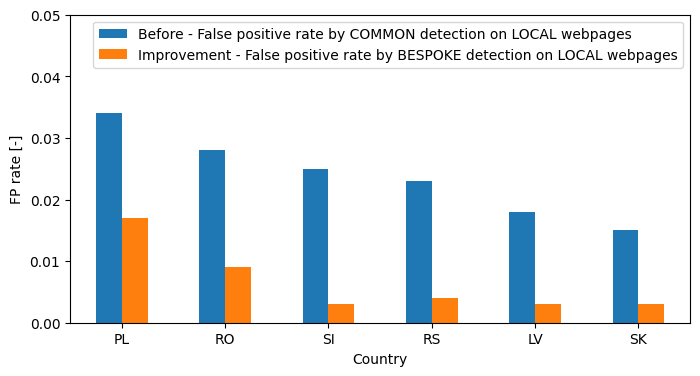

In [26]:
results_setA[['country','fp_common','fp_bespoke']].plot.bar(
    x='country',xlabel='Country', ylabel='FP rate [-]',figsize=(8,4),rot=0,ylim=[0,0.05])
plt.legend(['Before - False positive rate by COMMON detection on LOCAL webpages',
            'Improvement - False positive rate by BESPOKE detection on LOCAL webpages'])
plt.savefig(f'result-figures/fig-fp-country-minor-setA.pdf', bbox_inches='tight',pad_inches=0)

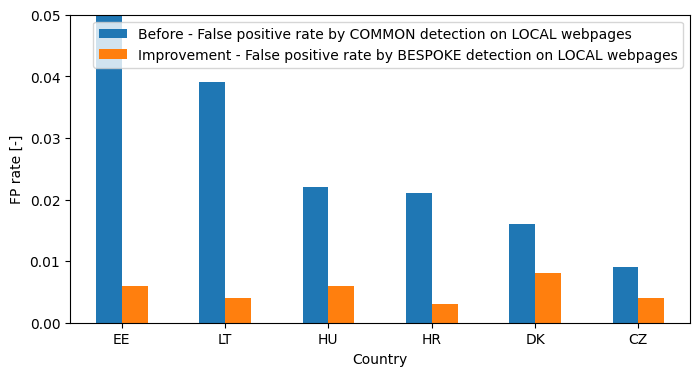

In [27]:
results_setB[['country','fp_common','fp_bespoke']].plot.bar(
    x='country',xlabel='Country', ylabel='FP rate [-]',figsize=(8,4),rot=0,ylim=[0,0.05])
plt.legend(['Before - False positive rate by COMMON detection on LOCAL webpages',
            'Improvement - False positive rate by BESPOKE detection on LOCAL webpages'])
plt.savefig(f'result-figures/fig-fp-country-minor-setB.pdf', bbox_inches='tight',pad_inches=0)

# Support data

In [28]:
# share of local webpages in countries on the web
sum_countries = 0
print(f'Webpages {len(generic_data)}')
counts = generic_data.tld.value_counts(normalize=True)
for item in COUNTRY_MI:
    country = counts[item.lower()]
    print(f'{item} {country.round(4)}')

Webpages 1000000
CZ 0.0114
DK 0.0058
EE 0.0016
HR 0.0021
HU 0.0067
LT 0.0017
LV 0.0011
PL 0.0139
RO 0.0045
RS 0.001
SI 0.0013
SK 0.003


CZ


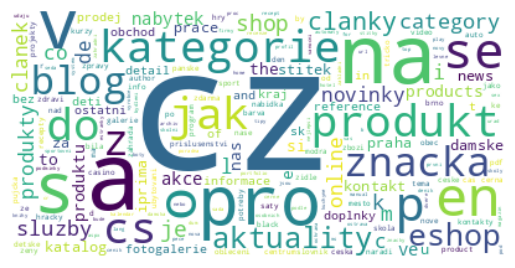

DK


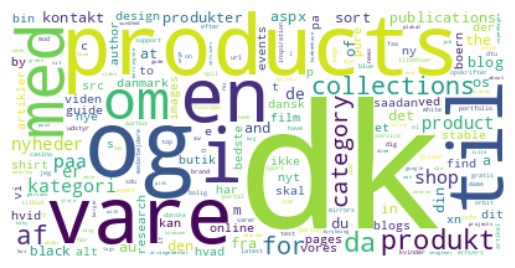

EE


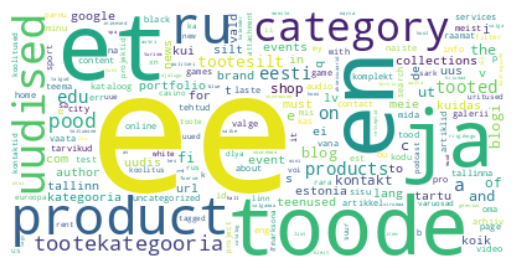

HR


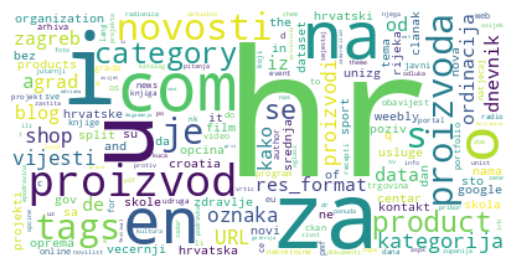

HU


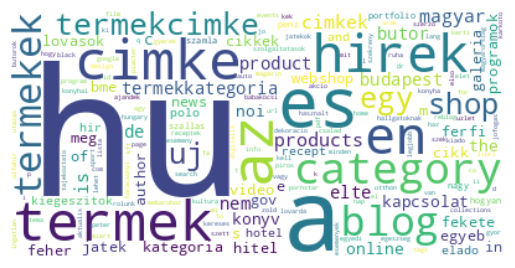

LT


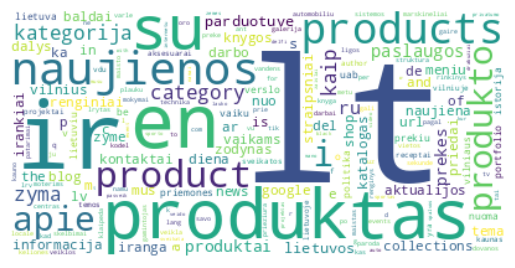

LV


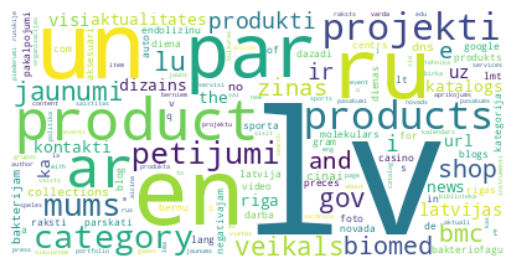

PL


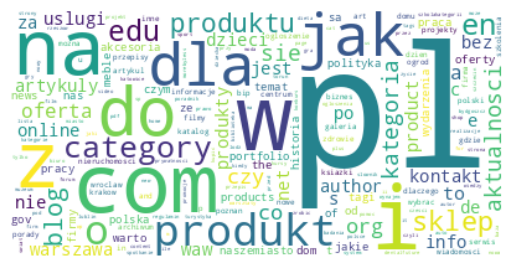

RO


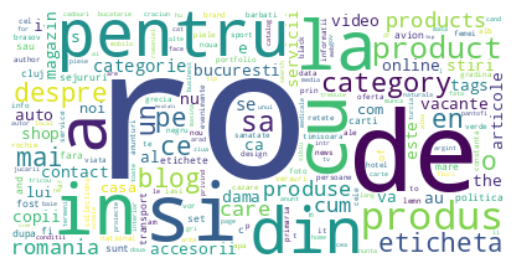

RS


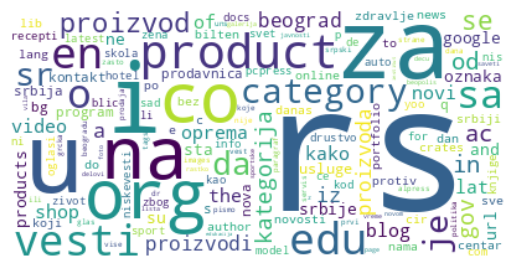

SI


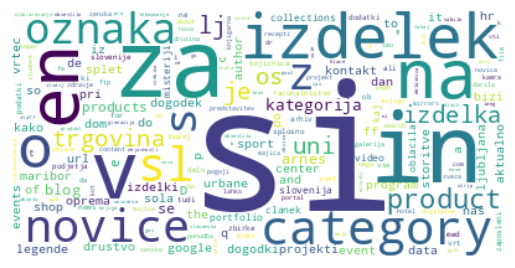

SK


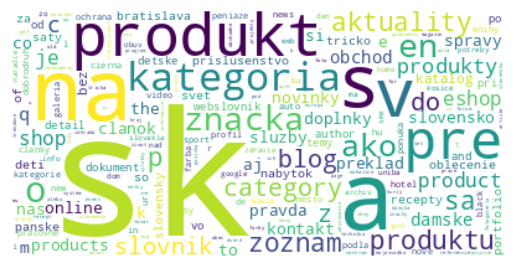

UK


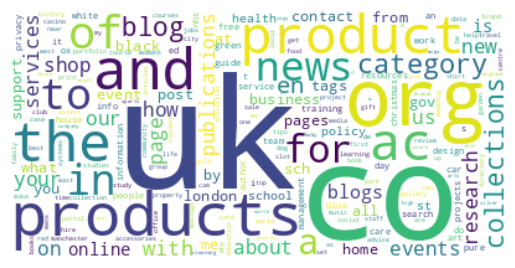

DE


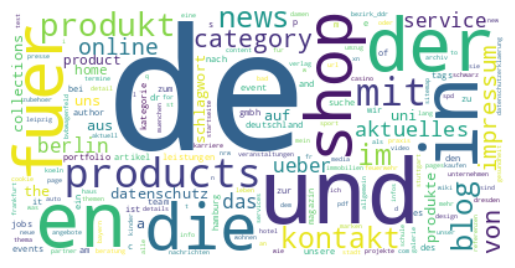

FR


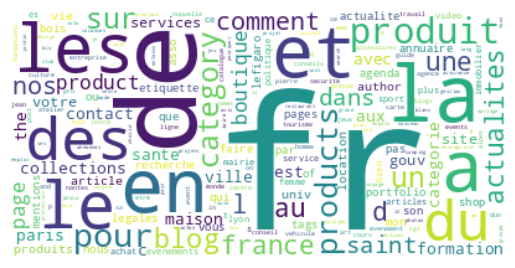

ES


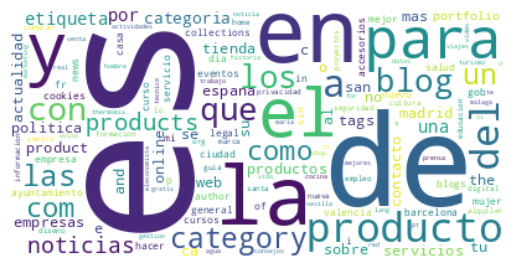

In [29]:
# word clouds for all countries
for item in COUNTRY_MI+COUNTRY_MJ:
    print(item)
    data = country_test.loc[country_test.country == item]
    plt = word_cloud(url=data.url)
    plt.savefig(f'result-figures/fig-word-cloud-{item}.pdf', bbox_inches='tight',pad_inches=0)
    plt.show()